# Covid-19: From model prediction to model predictive control

## A demo of a stochastic difference equation (SDE) SIR model

*Code by T.W. Alleman in consultation with the BIOMATH research unit headed by prof. Ingmar Nopens and prof. Jan baetens of the KERMIT research unit.*

Copyright (c) 2021 by T.W. Alleman, BIOMATH, Ghent University. All Rights Reserved.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from covid19model.models import models
from covid19model.data import mobility, sciensano, model_parameters

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
%autoreload 2

In [2]:
###############
## Load data ##
###############

# Time-integrated contact matrices
initN, Nc_all = model_parameters.get_integrated_willem2012_interaction_matrices()
levels = initN.size
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False)
# Sciensano public data
df_sciensano = sciensano.get_sciensano_COVID19_data(update=False)

In [3]:
############################
## Define a draw function ##
############################

def draw_fcn(param_dict,samples_dict):
    return param_dict

In [4]:
###################################
## Define social policy function ##
###################################

from covid19model.models.time_dependant_parameter_fncs import ramp_fun
def compliance_func(t, states, param, l, effectivity):
    # Convert tau and l to dates
    l_days = pd.Timedelta(l, unit='D')
    # Measures
    start_measures = pd.to_datetime('2020-03-15')
    if t <= start_measures:
        return param
    elif start_measures < t <= start_measures + l_days:
        return ramp_fun(param, effectivity*param, t, start_measures, l)
    else:
        return param * effectivity

In [5]:
###############################################
## Define new sort of social policy function ##
###############################################

from covid19model.models.time_dependant_parameter_fncs import ramp_fun
def compliance_func(t, states, param, l, effectivity):
    
    # Convert tau and l to dates
    l_days = pd.Timedelta(l, unit='D')
    # Define start of measures
    start_measures = pd.to_datetime('2020-03-15')
    # List of transitioning dates
    change_days = [start_measures,
                   start_measures + l_days]
    # List of transitioning values
    change_values = [param,
                     ramp_fun(param, effectivity*param, t, start_measures, l),
                     param * effectivity]
    # Return appropriate policy
    try:
        return change_values[[index for index,value in enumerate(change_days) if value > t][0]]
    except:
        return change_values[-1]

In [6]:
######################
## Initialize model ##
######################

# Define parameters
l = 12.5
effectivity = 0.13
params = {'beta': 0.020, 'gamma': 1/7, 'Nc': Nc_all['total'], 'l': l, 'effectivity': effectivity}
# Define initial states
initial_states = {"S": initN, "I": np.ones(9)}
# Initialize model (SDEs are discrete time models and require the discrete=True flag upon initialization)
model = models.simple_stochastic_SIR(initial_states, params, time_dependent_parameters={'Nc': compliance_func}, discrete=True)

In [7]:
########################
## Perform simulation ##
########################

n_draws = 20
start_sim = '2020-03-15'
end_sim = '2020-07-15'
out = model.sim(end_sim,start_date=start_sim,warmup=4,N=n_draws,draw_fcn=draw_fcn,samples={})

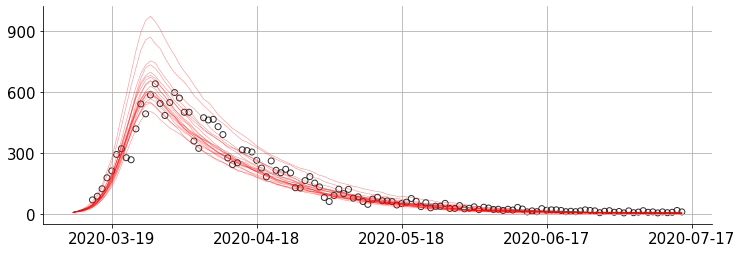

In [8]:
#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
for i in range(n_draws):
    ax.plot(out['time'],out['I'].sum(dim='Nc').isel(draws=i), color='red', alpha = 0.5, linewidth = 0.5)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

In [156]:
from covid19model.models.MPC import MPC

## Make a function to construct the MPC controller's predicition horizon

In [157]:
control_handles_dict = {'Nc': {
                                'continuous' : False,
                                'bounds_values' : [Nc_all['total'], Nc_all['total']*effectivity],
                                'costs' : [0, 100e6]
                                }
                       }

In [158]:
MPC = MPC(model, control_handles_dict)

In [159]:
values = [Nc_all['total']*effectivity,
          Nc_all['total']*effectivity*2,
          Nc_all['total']*effectivity,
          Nc_all['total']*effectivity*2,
          Nc_all['total']*effectivity,]
L = 14  

In [160]:
tryout_function = MPC.construct_horizon(values, L, 'Nc', pd.to_datetime('2020-05-01'))
t = pd.Timestamp('2020-03-21')
print(tryout_function(t,{},Nc_all['total'],l=l,effectivity=effectivity))

[[10.21856146  1.27862914  1.1676523   3.20481147  1.54226447  0.97224589
   0.6258913   0.21768621  0.16652361]
 [ 1.2530364  12.95922563  2.32922183  2.17700208  3.5342633   0.84912889
   0.29219359  0.30921587  0.08583158]
 [ 1.05286585  2.14314355  6.09914594  2.94646202  2.77373374  2.59381504
   0.47299168  0.18161809  0.18406278]
 [ 2.71594017  1.88259744  2.7692302   5.18390699  3.67830607  2.49521363
   0.96871428  0.40095722  0.10936159]
 [ 1.16792536  2.73109022  2.32949352  3.28689923  5.12780011  2.6061146
   1.03072721  0.75966064  0.21025496]
 [ 0.81437175  0.72577351  2.40949533  2.46624722  2.88259651  4.04088845
   1.22353617  0.43564707  0.349853  ]
 [ 0.68947195  0.32845001  0.57784543  1.25920279  1.49935748  1.60911807
   2.05964939  0.87058718  0.34337944]
 [ 0.31222014  0.45255637  0.28888806  0.67859448  1.43877667  0.74596458
   1.13350798  1.56238229  0.31638605]
 [ 0.37101399  0.19513829  0.45480051  0.2875157   0.61859226  0.93057952
   0.69449812  0.491475

## Try using the construct_horizon TDPF in a real model for verification

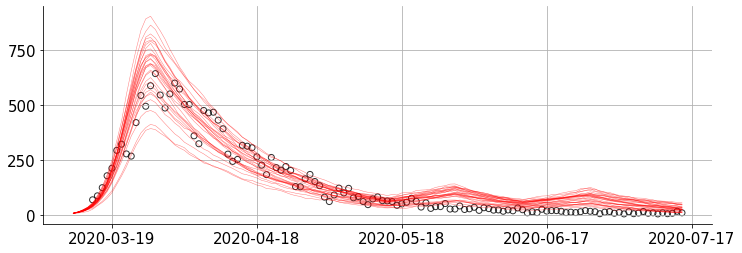

In [161]:
############################
## Change policy function ##
############################

model.time_dependent_parameters.update({'Nc': tryout_function})

########################
## Perform simulation ##
########################

n_draws = 30
start_sim = '2020-03-15'
end_sim = '2020-07-15'
out = model.sim(end_sim,start_date=start_sim,warmup=4,N=n_draws,draw_fcn=draw_fcn,samples={})

#######################
## Visualize results ##
#######################

fig, ax = plt.subplots(figsize=(12,4))
for i in range(n_draws):
    ax.plot(out['time'],out['I'].sum(dim='Nc').isel(draws=i), color='red', alpha = 0.5, linewidth = 0.5)
ax.scatter(df_sciensano[start_sim:end_sim].index,df_sciensano['H_in'][start_sim:end_sim],color='black',alpha=0.8,linestyle='None',facecolors='none')
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(4))
plt.show()
plt.close()

## Functions to compute the 'costs' of a proposed policy

In [ ]:
# To do: maybe rewrite so that array time is included in output 

In [176]:
MPC.cost_economic(out, {'I': 5*25000*0.214}, {'Nc': [Nc_all['total'], Nc_all['total']*effectivity]}, L)/1e6

1956.836025

In [177]:
MPC.cost_setpoint(out, ['I'], [0], [500])

3478139144.9999995

## Next step: write a function to convert a (pso) parameter estimate in a series of horizons

## Next step: Write the wrapper to go from: pso proposed policy --> cost using the above work